In [209]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import pytesseract
from PIL import Image
import random
import os
%matplotlib inline

In [210]:
images_dir = "D:\VIT\sem1-2\projects\SET\invictus-master\data\images"
image_files = os.listdir(images_dir)
image_path = "{}/{}".format(images_dir, "3.jpg")
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [211]:
def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)

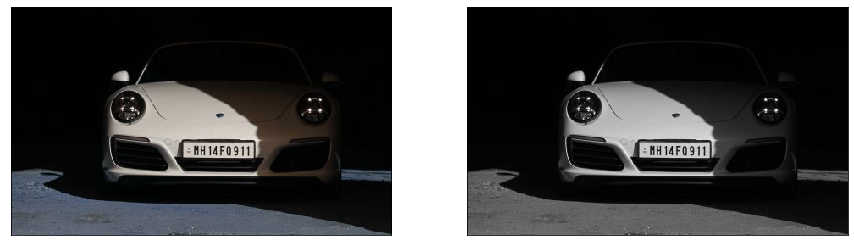

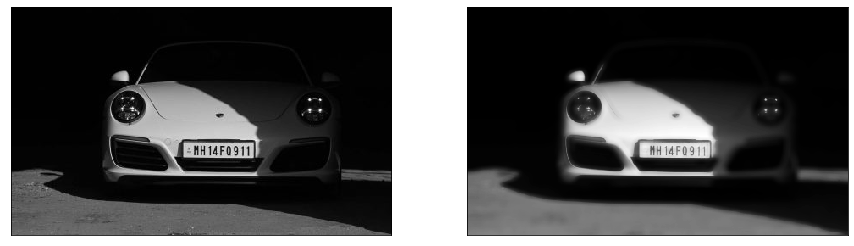

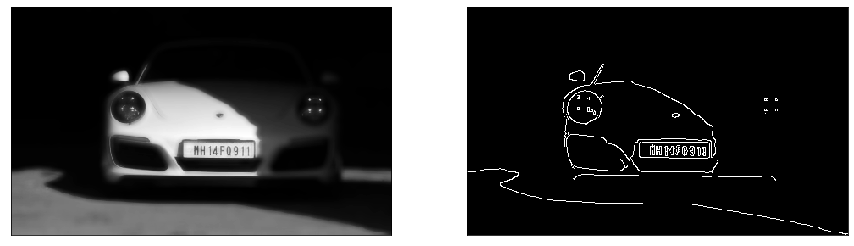

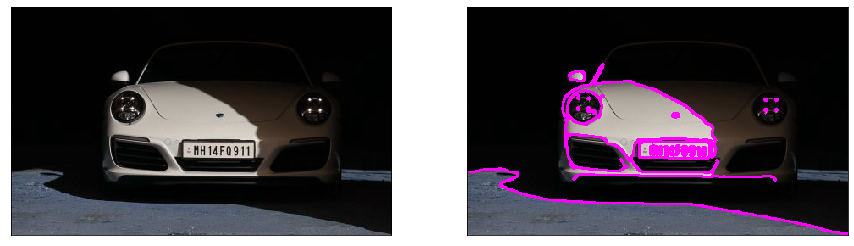

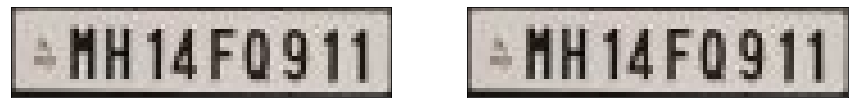

In [212]:
plot_images(image, gray)
blur = cv2.bilateralFilter(gray, 11,90, 90)
plot_images(gray, blur)
edges = cv2.Canny(blur, 30, 200)
plot_images(blur, edges)
cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
image_copy = image.copy()
_ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)
plot_images(image, image_copy)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]
image_copy = image.copy()
_ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)
plate = None
for c in cnts:
    perimeter = cv2.arcLength(c, True)
    edges_count = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(edges_count) ==4:
        x,y,w,h = cv2.boundingRect(c)
        plate = image[y:y+h, x:x+w]
        break

cv2.imwrite("plate.png", plate)
plot_images(plate, plate)

In [213]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [214]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 80))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

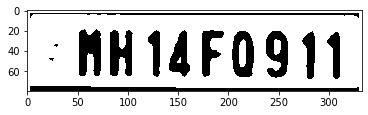

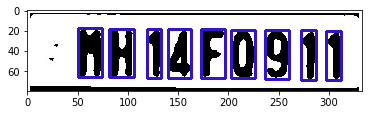

In [215]:
img = cv2.imread('plate.png')
char = segment_characters(img)

In [216]:
#l=len(char)
#for i in range(l):
 #   plt.subplot(1,l, i+1)
  #  plt.imshow(char[i], cmap='gray')
   # plt.axis('off')



In [217]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
text=pytesseract.image_to_string('contour.jpg')
print(text)

- MH14F0911


In [218]:
res1 = "" 
for i in text: 
    if i.isalnum(): 
        res1 = "".join([res1, i]) 
  
  
# printing resultant string 
print ("vehNum is: ", str(res1).upper()) 
vehNum=str(res1.upper())

vehNum is:  MH14F0911


In [219]:
df=pd.read_csv('veh1.csv',header=0)
display(df.head())

,VehicleNo,RC,Insurance,Airpollution
0,DL8CAF5030,25-05-2035,25-05-2020,25-03-2020
1,AP16CK1865,19-09-2022,19-09-2020,21-06-2020
2,HR26DT6103,18-09-2022,18-09-2020,18-06-2020
3,MH14GY1272,21-06-2035,20-06-2022,21-12-2020
4,MH20DV2363,31-12-2040,31-12-2023,31-06-2021


In [221]:
from datetime import date
df['RC'] = pd.to_datetime(df['RC'],errors='coerce')
df['Insurance'] = pd.to_datetime(df['Insurance'],errors='coerce')
df['Airpollution'] = pd.to_datetime(df['Airpollution'],errors='coerce')
today = pd.to_datetime('today')
#print(df.head())
row1=df[df['VehicleNo']==vehNum]
print(row1)
print()
if(row1.empty):
    print("\n NOT Registred")
else:
    sum=0
    if (row1.RC<today).bool():
        sum+=1500
        print('Fine for Not having RC : 1500')
    if (row1.Insurance<today).bool():
        sum+=1000
        print('Fine for Not having Insurance : 1000')
    if (row1.Airpollution<today).bool():
        sum+=700
        print('Fine for Not having Airpollution : 700')
    if(sum>0):
        print("\n \nThe total sum of fine is : "+str(sum))
    else:
        print('\n ALL CLEAR NO FINE')

   VehicleNo         RC  Insurance Airpollution
6  MH14F0911 2020-04-25 2019-04-25   2019-04-21

Fine for Not having RC : 1500
Fine for Not having Insurance : 1000
Fine for Not having Airpollution : 700

 
The total sum of fine is : 3200
